## Read data

In [ ]:
# Read in multiple lists from json files
import json
from pathlib import Path

def read_json_file(filename):
    with open(filename, 'r') as f:
        return json.load(f)

# Read in the lists and add file names as keys
eval_result_jsons = [

    "HotpotQA/retrieval_score/joint_optim/gpt_3.5_0125_compiled_joint_optim_2hops2passagesperhop_retrieval_eval_results.json",
    "HotpotQA/retrieval_score/accuracy/gpt_3.5_0125_compiled_acc_optim_2hops2passagesperhop_retrieval_eval_results.json",
    "HotpotQA/retrieval_score/formatting_instr_only/gpt_3.5_0125_format_instr_2hops2passagesperhop_retrieval_eval_results.json",
    "HotpotQA/retrieval_score/uncompiled/gpt_3.5_0125_uncompiled_2hops2passagesperhop_retrieval_eval_results.json",


    "HotpotQA/retrieval_score/formatting_instr_only/llama3_70B_format_instr_2hops2passagesperhop_retrieval_eval_results.json",
    "HotpotQA/retrieval_score/accuracy/llama3_70B_compiled_acc_optim_2hops2passagesperhop_retrieval_eval_results.json",
    "HotpotQA/retrieval_score/joint_optim/llama3_70B_compiled_joint_optim_2hops2passagesperhop_retrieval_eval_results.json",
    "HotpotQA/retrieval_score/uncompiled/llama3_70B_uncompiled_2hops2passagesperhop_retrieval_eval_results.json",

    ]

eval_results = {}
for file in eval_result_jsons:
    print(file)
    filename = Path(file).stem
    eval_results[filename] = read_json_file(file)

In [ ]:
eval_results_clean = {}
for filename, results in eval_results.items():

    print(f"\n{filename}")

    if "joint_optim" in filename:
        print(results[0]['per_task_results'].keys())

        for program in results:
            # Calculating the sums of prompt and completion tokens
            run_eval_prompt_tokens = []
            run_eval_completion_tokens = []
            for run_name, run in program['per_task_results'].items():
                total_prompt_tokens = 0
                total_completion_tokens = 0
                for task in run:
                    total_prompt_tokens += task['prompt_tokens']
                    total_completion_tokens += task['completion_tokens']
                run_eval_prompt_tokens.append(total_prompt_tokens)
                run_eval_completion_tokens.append(total_completion_tokens)
            
            run_eval_prompt_tokens = {f"run{i+1}": x for i, x in enumerate(run_eval_prompt_tokens)}
            run_eval_completion_tokens = {f"run{i+1}": x for i, x in enumerate(run_eval_completion_tokens)}
            program['eval_prompt_tokens'] = run_eval_prompt_tokens
            program['eval_completion_tokens'] = run_eval_completion_tokens

        eval_results_clean[filename] = results
    else:
        run_accuracies = []
        run_gold_passage_accuracies = []
        run_costs = []
        run_compile_costs = []
        run_eval_prompt_tokens = []
        run_eval_completion_tokens = []
        run_compile_prompt_tokens = []
        run_compile_completion_tokens = []
        for run in results:
            run_accuracies.append(run['eval_accuracies']['run1'])
            if "retrieval" in filename:
                run_gold_passage_accuracies.append(run['eval_gold_passages_retrieved_accuracies']['run1'])
            run_costs.append(run['eval_costs']['run1'])
            run_compile_costs.append(run.get('compile_cost', {}))

            # Calculating the sums of prompt and completion tokens
            total_prompt_tokens = 0
            total_completion_tokens = 0
            if "retrieval" in filename and "acc" in filename:
                for task in run['per_task_results']:
                    total_prompt_tokens += task['prompt_tokens']
                    total_completion_tokens += task['completion_tokens']
            else:
                for task in run['per_task_results']['run1']:
                    total_prompt_tokens += task['prompt_tokens']
                    total_completion_tokens += task['completion_tokens']

            run_eval_prompt_tokens.append(total_prompt_tokens)
            run_eval_completion_tokens.append(total_completion_tokens)

            # compile tokens
            run_compile_prompt_tokens.append(run['compile_prompt_tokens'])
            run_compile_completion_tokens.append(run['compile_completion_tokens'])
            

        run_accuracies = {f"run{i+1}": x for i, x in enumerate(run_accuracies)}
        if "retrieval" in filename:
            run_gold_passage_accuracies = {f"run{i+1}": x for i, x in enumerate(run_gold_passage_accuracies)}
        run_costs = {f"run{i+1}": x for i, x in enumerate(run_costs)}
        run_compile_costs = {f"run{i+1}": x for i, x in enumerate(run_compile_costs)}
        run_eval_prompt_tokens = {f"run{i+1}": x for i, x in enumerate(run_eval_prompt_tokens)}
        run_eval_completion_tokens = {f"run{i+1}": x for i, x in enumerate(run_eval_completion_tokens)}
        run_compile_prompt_tokens = {f"run{i+1}": x for i, x in enumerate(run_compile_prompt_tokens)}
        run_compile_completion_tokens = {f"run{i+1}": x for i, x in enumerate(run_compile_completion_tokens)}


        if "retrieval" in filename:
            eval_results_clean[filename] = [{
                'eval_accuracies': run_accuracies,
                'eval_gold_passages_retrieved_accuracies': run_gold_passage_accuracies,
                'compile_cost': run_compile_costs,
                'eval_costs': run_costs,
                'compile_prompt_tokens': run_compile_prompt_tokens,
                'compile_completion_tokens': run_compile_completion_tokens,
                'eval_prompt_tokens': run_eval_prompt_tokens,
                'eval_completion_tokens': run_eval_completion_tokens,
                
            }]
        else:
            eval_results_clean[filename] = [{
                'eval_accuracies': run_accuracies,
                'eval_costs': run_costs,
                'compile_cost': run_compile_costs,
                'compile_prompt_tokens': run_compile_prompt_tokens,
                'compile_completion_tokens': run_compile_completion_tokens,
                'prompt_tokens': run_eval_prompt_tokens,
                'completion_tokens': run_eval_completion_tokens
            }]


## Main paper

In [4]:
from scipy import stats

def confidence_interval(data, confidence=0.95):
    """
    Calculate the 95% confidence interval for a list of values using the Student's t-distribution.

    Parameters:
    data (list or numpy array): The input data values.
    confidence (float): The confidence level. Default is 0.95 for a 95% confidence interval.

    Returns:
    tuple: Lower bound and upper bound of the confidence interval.
    """
    # Convert data to numpy array
    data = np.array(data)
    
    # Calculate the sample mean
    mean = np.mean(data)
    
    # Calculate the sample standard deviation
    std_err = stats.sem(data)  # Standard error of the mean
    
    # Calculate the degrees of freedom
    degrees_freedom = len(data) - 1
    
    # Calculate the t-critical value for the given confidence level and degrees of freedom
    t_critical = stats.t.ppf((1 + confidence) / 2, degrees_freedom)
    
    # Calculate the margin of error
    margin_of_error = t_critical * std_err
    
    # Calculate the confidence interval
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    
    return lower_bound, upper_bound

Best program: gpt_3.5_0125_compiled_joint_optim_2hops2passagesperhop_retrieval_eval_results
Mean accuracy: 0.509
Max accuracy: 0.54
Min accuracy: 0.475
Mean eval cost: 0.3475475
Max eval cost: 0.35046950000000004
Min eval cost: 0.34574900000000003
Compile cost: 2.714242
Best program: gpt_3.5_0125_compiled_acc_optim_2hops2passagesperhop_retrieval_eval_results
Mean accuracy: 0.5
Max accuracy: 0.55
Min accuracy: 0.45
Mean eval cost: 0.8196479999999999
Max eval cost: 0.8678164999999999
Min eval cost: 0.7420045000000002
Mean compile cost: 0.0526582
Max compile cost: 0.0610955
Min compile cost: 0.0331645
Best program: gpt_3.5_0125_format_instr_2hops2passagesperhop_retrieval_eval_results
Mean accuracy: 0.37700000000000006
Max accuracy: 0.39
Min accuracy: 0.36
Mean eval cost: 0.14174989999999993
Max eval cost: 0.14303349999999995
Min eval cost: 0.13973399999999989
Mean compile cost: 0.0
Max compile cost: 0.0
Min compile cost: 0.0
Best program: gpt_3.5_0125_uncompiled_2hops2passagesperhop_retri

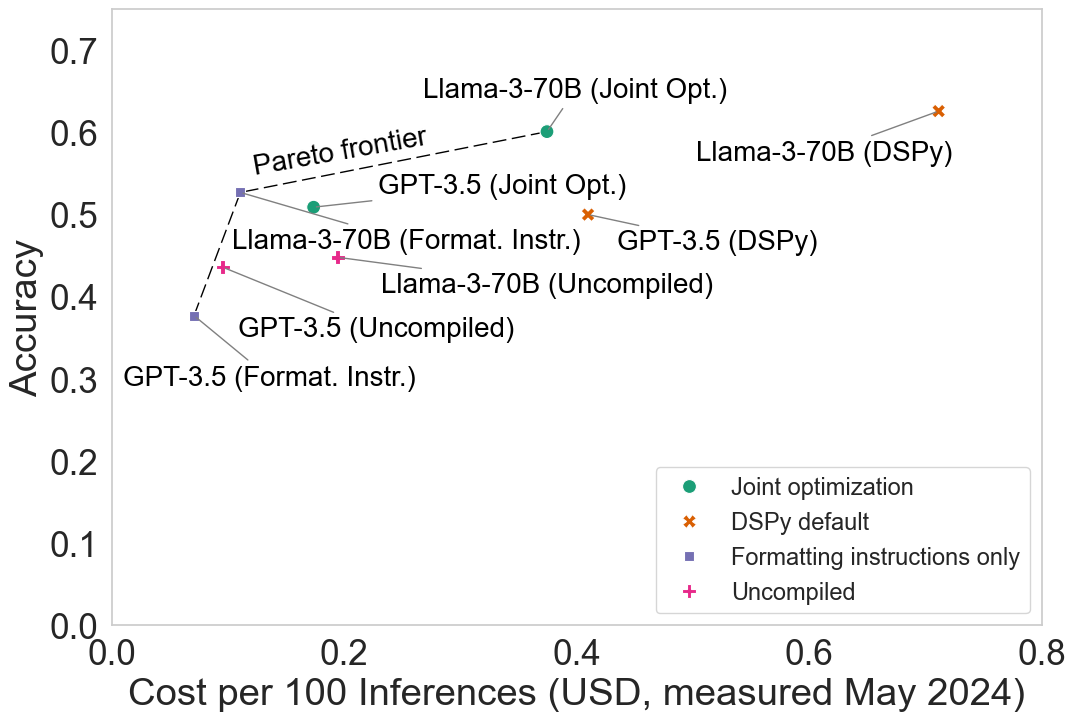

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2.3)  #

# Define a dictionary mapping model names to marker styles
marker_styles = {
    "Llama-3-70B": "S",
    "GPT-3.5": "s",
}

model_name_dict = {
    "llama3_70B_format_instr_2hops2passagesperhop_retrieval_eval_results": "Llama-3-70B",
    "llama3_70B_compiled_acc_optim_2hops2passagesperhop_retrieval_eval_results": "Llama-3-70B",
    "llama3_70B_compiled_joint_optim_2hops2passagesperhop_retrieval_eval_results": "Llama-3-70B",
    "llama3_70B_uncompiled_2hops2passagesperhop_retrieval_eval_results": "Llama-3-70B",

    "gpt_3.5_0125_compiled_acc_optim_2hops2passagesperhop_retrieval_eval_results": "GPT-3.5",
    "gpt_3.5_0125_compiled_joint_optim_2hops2passagesperhop_retrieval_eval_results": "GPT-3.5",
    "gpt_3.5_0125_format_instr_2hops2passagesperhop_retrieval_eval_results": "GPT-3.5",
    "gpt_3.5_0125_uncompiled_2hops2passagesperhop_retrieval_eval_results": "GPT-3.5",
}



# filter eval_results_clean for keys in model_name_dict
eval_results_filtered = {k: v for k, v in eval_results_clean.items() if k in model_name_dict.keys()}

# for each model in eval_results_filtered, only keep the program in the list with the highest mean accuracy across all runs in eval_accuracies
eval_results_filtered_best = {}
for filename, eval_result in eval_results_filtered.items():
    if "joint" in filename:
        best_accuracy = 0
        best_program = None
        for program in eval_result:
            dev_acc = program['trainset_acc']
            if dev_acc > best_accuracy:
                best_accuracy = dev_acc
                best_program = program
        eval_results_filtered_best[filename] = [best_program]
    else:
        eval_results_filtered_best[filename] = eval_result
    
    relevant_keys_dict = {k: eval_results_filtered_best[filename][0][k] for k in ['eval_gold_passages_retrieved_accuracies', 'eval_costs', 'compile_cost'] if k in eval_results_filtered_best[filename][0]}
    print("Best program:", filename)

    print("Mean accuracy:", np.mean(list(relevant_keys_dict['eval_gold_passages_retrieved_accuracies'].values())))
    print("Max accuracy:", max(list(relevant_keys_dict['eval_gold_passages_retrieved_accuracies'].values())))
    print("Min accuracy:", min(list(relevant_keys_dict['eval_gold_passages_retrieved_accuracies'].values())))

    print("Mean eval cost:", np.mean(list(relevant_keys_dict['eval_costs'].values())))
    print("Max eval cost:", max(list(relevant_keys_dict['eval_costs'].values())))
    print("Min eval cost:", min(list(relevant_keys_dict['eval_costs'].values())))

    if type(relevant_keys_dict['compile_cost']) == dict:
        print("Mean compile cost:", np.mean(list(relevant_keys_dict['compile_cost'].values())))
        print("Max compile cost:", max(list(relevant_keys_dict['compile_cost'].values())))
        print("Min compile cost:", min(list(relevant_keys_dict['compile_cost'].values())))
    else:
        print("Compile cost:", relevant_keys_dict['compile_cost'])



# get data for plotting
x = []
x_err_minmax = []
x_err_95ci = []
y = []
y_err_minmax = []
y_err_95ci = []
joint_optimized = []
model_name = []
compile_cost = []
for filename, eval_result in eval_results_filtered_best.items():
    for program in eval_result:
        print(filename, program)
        if type(program['compile_cost']) == dict:
            compile_cost.append(sum(program['compile_cost'].values())/len(program['compile_cost'].values()))
        else:
            compile_cost.append(program['compile_cost'])
        
        x_mean = sum(program['eval_costs'].values())/len(program['eval_costs'])
        x.append(x_mean)
        print("cost per 100 inferences", x_mean/2) # per 100 inferences

        x_err_95ci_lower,x_err_95ci_upper = confidence_interval(list(program['eval_costs'].values()))
        x_err_95ci.append([x_mean - x_err_95ci_lower, x_err_95ci_upper - x_mean])
        x_err_minmax.append([[x_mean - min(program['eval_costs'].values())],[max(program['eval_costs'].values()) - x_mean]])

        y_mean = sum(program['eval_gold_passages_retrieved_accuracies'].values())/len(program['eval_gold_passages_retrieved_accuracies'])
        y.append(y_mean)
        print("accuracy", y_mean)

        y_err_95ci_lower,y_err_95ci_upper = confidence_interval(list(program['eval_gold_passages_retrieved_accuracies'].values()))
        y_err_95ci.append([y_mean - y_err_95ci_lower, y_err_95ci_upper - y_mean])
        y_err_minmax.append([[y_mean - min(program['eval_gold_passages_retrieved_accuracies'].values())],[max(program['eval_gold_passages_retrieved_accuracies'].values()) - y_mean]])
        optimizer = "Uncompiled"
        if "joint_optim" in filename:
            optimizer = "Joint optimization"
        elif "acc_optim" in filename:
            optimizer = "DSPy default"
        elif "format_instr" in filename:
            optimizer = "Formatting instructions only"
        joint_optimized.append(optimizer)
        model_name.append(model_name_dict[filename])
x_err_minmax = np.array(x_err_minmax).reshape(-1, 2)
y_err_minmax = np.array(y_err_minmax).reshape(-1, 2)
x_err_95ci = np.array(x_err_95ci).reshape(-1, 2)
y_err_95ci = np.array(y_err_95ci).reshape(-1, 2)
markers = [marker_styles[model] for model in model_name]



# get cost per 100 inferences (200 samples in test set so div by 2)
x = [p/2 for p in x]

# Create the scatter plot with error bars
f, (ax) = plt.subplots(1,1, figsize=(12, 8))
f.subplots_adjust(wspace=0.015)
# Creating the scatter plot with a color map based on 'joint_optimized'
if joint_optimized.count(False) == len(joint_optimized):
    scatter = plt.scatter(x, y, c='blue', alpha=.7)
else:
    scatter_plot = sns.scatterplot(
    x=x,
    y=y,
    hue=joint_optimized,
    style=joint_optimized,
    palette=sns.color_palette("Dark2")[:4], 
    # style=model_name,
    s=100,
    zorder=2,
    ax=ax
    )


# Setting the title and labels
ax.set_ylabel('Accuracy')
ax.set_xlabel('Cost per 100 Inferences (USD, measured May 2024)')
plt.grid(True)

# Setting the y-axis limits
plt.ylim(0, .75)
ax.set_xlim(0,0.8)

# plot ticks on x axis every 5 units
ax.set_xticks([0,.2, .4, .6, .8])

ax.grid(False)


# Define the points for the Pareto frontier line
pareto_color = "black"
pareto_x = [0.14174989999999993, 0.22148478000000008, 0.7489870200000002]
pareto_x = [p/2 for p in pareto_x]
pareto_y = [0.37700000000000006, 0.5269999999999999, 0.601]
ax.plot(pareto_x, pareto_y, linestyle='dashed', color=pareto_color, zorder=0, linewidth=1, dashes=(10, 4))
ax.text(pareto_x[1]+0.01, pareto_y[1]+0.015, 'Pareto frontier', fontsize=20, color=pareto_color, ha='left', va='bottom', rotation=10) # log scale
# plt.text(pareto_x[0]+0.022, pareto_y[0]+0.035, 'Pareto frontier', fontsize=12, color=pareto_color, ha='left', va='bottom', rotation=54) 


# Implementing label adjustments using simple lines
strategy_renames = {
    "DSPy default": "DSPy",
    "Formatting instructions only": "Format. Instr.",
    "Joint optimization": "Joint Opt.",
    "Uncompiled": "Uncompiled"
}
for i in range(len(x)):
    annotation_text = f"{model_name[i]} ({strategy_renames[joint_optimized[i]]})"
    x_point = x[i]
    y_point = y[i]
    
    print(annotation_text)
    # Define the xytext position for each label (customize as needed)
    if annotation_text == "GPT-3.5 (Joint Opt.)":
        xytext = (225, 15)
    elif annotation_text == "GPT-3.5 (Format. Instr.)":
        xytext = (160,-45)
    elif annotation_text == "GPT-3.5 (DSPy)":
        xytext = (165,-20)
    elif annotation_text == "GPT-3.5 (Uncompiled)":
        xytext = (210, -45)
    elif annotation_text == "Llama-3-70B (Format. Instr.)":
        xytext = (245, -35) # Adjust position for Llama-3-70B
    elif annotation_text == "Llama-3-70B (Joint Opt.)":
        xytext = (130, 30)
    elif annotation_text == "Llama-3-70B (Uncompiled)":
        xytext = (270, -20)
    elif annotation_text == "Llama-3-70B (DSPy)":
        xytext = (10, -30)
    elif model_name[i] == "Llama-3-8B":
        xytext = (10, -20)  # Adjust position for Llama-3-8B
    elif model_name[i] == "GPT-4":
        xytext = (10, -20)  # Adjust position for GPT-4
    else:
        xytext = (10, -5)  # Default position

    ### WITHOUT OPTIM. LABELS AT POINTS
    # # Define the xytext position for each label (customize as needed)
    # if annotation_text == "GPT-3.5 (Joint Opt.)":
    #     xytext = (120, 10)
    #     annotation_text = "GPT-3.5"
    # elif annotation_text == "GPT-3.5 (Format. Instr.)":
    #     xytext = (20,-40)
    #     annotation_text = "GPT-3.5"
    # elif annotation_text == "GPT-3.5 (DSPy)":
    #     xytext = (70,-30)
    #     annotation_text = "GPT-3.5"
    # elif annotation_text == "GPT-3.5 (Uncompiled)":
    #     xytext = (85, -30)
    #     annotation_text = "GPT-3.5"
    # elif annotation_text == "Llama-3-70B (Format. Instr.)":
    #     xytext = (110, -32) # Adjust position for Llama-3-70B
    #     annotation_text = "Llama-3-70B"
    # elif annotation_text == "Llama-3-70B (Joint Opt.)":
    #     xytext = (130, 30)
    #     annotation_text = "Llama-3-70B"
    # elif annotation_text == "Llama-3-70B (Uncompiled)":
    #     xytext = (130, -30)
    #     annotation_text = "Llama-3-70B"
    # elif annotation_text == "Llama-3-70B (DSPy)":
    #     xytext = (10, -30)
    #     annotation_text = "Llama-3-70B"
    # else:
    #     xytext = (10, -5)  # Default position

    # Add annotations
    scatter_plot.annotate(
        annotation_text,
        xy=(x_point, y_point),
        xycoords='data',
        xytext=xytext,
        textcoords='offset points',
        size=20,
        ha='right',
        va='center',
        color='black',
        arrowprops=dict(arrowstyle="-", color='gray'),
    )


# hide legend
ax.legend(loc="lower right", fontsize=17)
plt.show()


### fix vs variable cost

In [7]:
joint_optimized

# get compile cost per model per optimization strategy and store in a dictionary
compile_cost_per_model = {}
for i, model in enumerate(model_name):
    if model not in compile_cost_per_model:
        compile_cost_per_model[model] = {}
    compile_cost_per_model[model][joint_optimized[i]] = {
        "cost_per_100": x[i],
        "compile_cost": compile_cost[i]
    }
    
compile_cost_per_model

{'GPT-3.5': {'Joint optimization': {'cost_per_100': 0.17377375,
   'compile_cost': 2.714242},
  'DSPy default': {'cost_per_100': 0.40982399999999997,
   'compile_cost': 0.0526582},
  'Formatting instructions only': {'cost_per_100': 0.07087494999999996,
   'compile_cost': 0.0},
  'Uncompiled': {'cost_per_100': 0.09547675000000003, 'compile_cost': 0.0}},
 'Llama-3-70B': {'Formatting instructions only': {'cost_per_100': 0.11074239000000004,
   'compile_cost': 0.0},
  'DSPy default': {'cost_per_100': 0.7114494600000001,
   'compile_cost': 0.040717800000000005},
  'Joint optimization': {'cost_per_100': 0.3744935100000001,
   'compile_cost': 3.8435571000000004},
  'Uncompiled': {'cost_per_100': 0.1944116099999998, 'compile_cost': 0.0}}}

In [15]:
points = {
    "Llama-3-70B DSPy default": {"x": compile_cost_per_model['Llama-3-70B']['DSPy default']['cost_per_100']/100, 
                                   "fixed_cost": compile_cost_per_model['Llama-3-70B']['DSPy default']['compile_cost']},
    "Llama-3-70B Joint optimizer": {"x": compile_cost_per_model['Llama-3-70B']['Joint optimization']['cost_per_100']/100, 
                                   "fixed_cost": compile_cost_per_model['Llama-3-70B']['Joint optimization']['compile_cost']},
    "GPT-3.5 DSPy default": {"x": compile_cost_per_model['GPT-3.5']['DSPy default']['cost_per_100']/100,
                               "fixed_cost": compile_cost_per_model['GPT-3.5']['DSPy default']['compile_cost']},
    "GPT-3.5 Joint optimizer": {"x": compile_cost_per_model['GPT-3.5']['Joint optimization']['cost_per_100']/100,
                               "fixed_cost": compile_cost_per_model['GPT-3.5']['Joint optimization']['compile_cost']},  
}

In [16]:
import sympy as sp

def calculate_intersections(points):
    intersections = {}
    models = list(points.keys())
    
    for i in range(0, len(models), 2):
        model1 = models[i]
        model2 = models[i + 1]
        
        fixed_cost1 = points[model1]['fixed_cost']
        variable_cost1 = points[model1]['x']
        
        fixed_cost2 = points[model2]['fixed_cost']
        variable_cost2 = points[model2]['x']
        
        # Define the number of inferences as a symbolic variable
        x = sp.symbols('x')
        
        # Define the cost functions symbolically
        cost1 = fixed_cost1 + variable_cost1 * x
        cost2 = fixed_cost2 + variable_cost2 * x
        
        # Solve for the intersection point
        intersection = sp.solve(cost1 - cost2, x)
        
        intersections[f'{model1} and {model2}'] = intersection[0]
    
    return intersections

calculate_intersections(points)

{'Llama-3-70B DSPy default and Llama-3-70B Joint optimizer': 1128.58648140803,
 'GPT-3.5 DSPy default and GPT-3.5 Joint optimizer': 1127.54966368390}

/tmp/ipykernel_3967395/4037016248.py:61: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = plt.scatter([], [], c=color, marker='o')
/tmp/ipykernel_3967395/4037016248.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_points_joint = df.groupby(["Model", "Strategy"]).apply(lambda x: x.nlargest(1, 'Number of Inferences')).reset_index(drop=True)


GPT-3.5
GPT-3.5
Llama-3-70B
Llama-3-70B


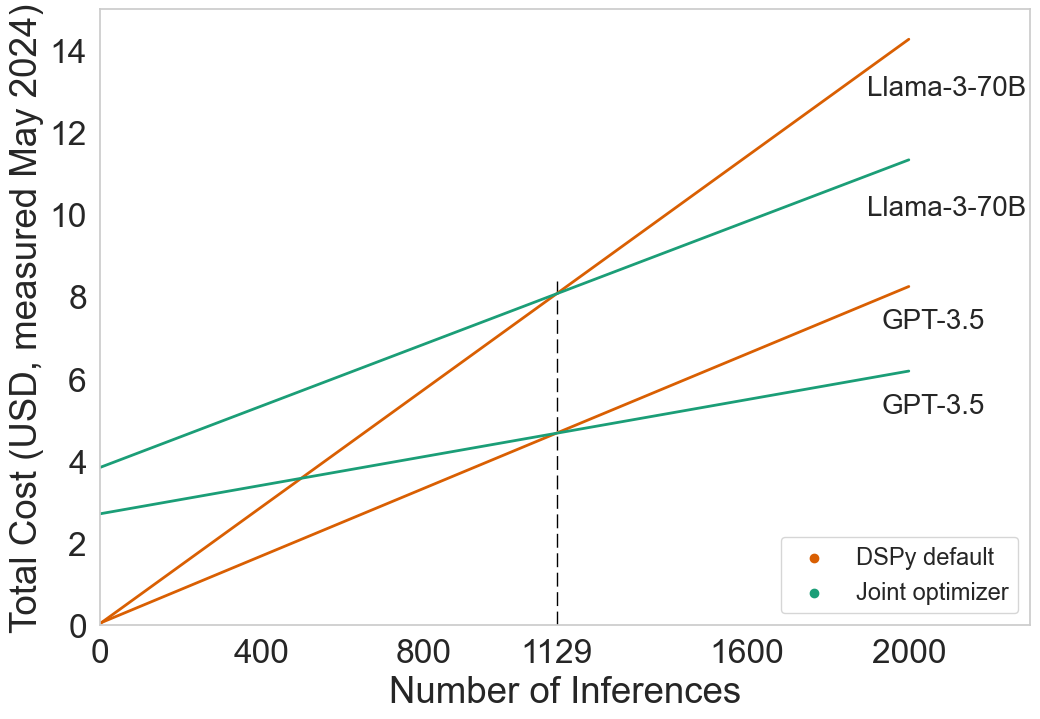

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2.2) 


palette = sns.color_palette("Dark2", 2)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Transforming dictionary into a DataFrame
data = []
for model, costs in points.items():
    x = costs["x"]
    fixed_cost = costs["fixed_cost"]
    strategy = "Joint optimizer" if "joint" in model.lower() else "DSPy default"
    model_name = model.replace("Joint optimizer", "").replace("DSPy default", "").replace(" ", "")
    for nr_inference in range(1, 2001):
        total_cost = fixed_cost + x * nr_inference
        data.append({"Model": model_name, "Strategy": strategy, "Number of Inferences": nr_inference, "TotalCost": total_cost})

df = pd.DataFrame(data)


def find_intersections(df):
    intersections = []
    models = df["Model"].unique()
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            df1 = df[df["Model"] == models[i]]
            df2 = df[df["Model"] == models[j]]
            for k in range(1, 2001):  # Increase the range for a more comprehensive analysis
                cost1 = df1[df1["Number of Inferences"] == k]["TotalCost"].values
                cost2 = df2[df2["Number of Inferences"] == k]["TotalCost"].values
                if len(cost1) > 0 and len(cost2) > 0 and cost1[0] == cost2[0]:
                    intersections.append((models[i], models[j], k, cost1[0]))
                    break
    return intersections

# Finding intersections
intersections = find_intersections(df)


blue = sns.color_palette("Dark2")[0]
orange = sns.color_palette("Dark2")[1]
green = sns.color_palette("Dark2")[2]
color_dict = {
'Joint optimizer': blue,
 'DSPy default': orange,
 }

# LEGEND
colors = [orange, blue]
labels = ['DSPy default', 'Joint optimizer']
# Create empty scatter plots as legend handles
legend_handles = []
for color in colors:
    handle = plt.scatter([], [], c=color, marker='o')
    legend_handles.append(handle)
ax.legend(handles=legend_handles, labels=labels, loc="lower right", fontsize=17)

# Plotting using Seaborn
sns.lineplot(data=df, 
             x="Number of Inferences", 
             y="TotalCost", 
             hue="Strategy", 
             style="Model", 
             dashes=False,
             linewidth=2,
             legend=None,
             palette=color_dict)

# Annotating lines for Joint optimizer
last_points_joint = df.groupby(["Model", "Strategy"]).apply(lambda x: x.nlargest(1, 'Number of Inferences')).reset_index(drop=True)
for line in last_points_joint.itertuples():
    print(line.Model)
    if line.Strategy == "DSPy default" and line.Model == "GPT-3.5":
        plt.annotate(line.Model, xy=(line._3, line.TotalCost), xytext=(-20, -25), textcoords='offset points', ha='left', va='center', fontsize=20)
    elif line.Model == "Llama-3-70B":
        plt.annotate(line.Model, xy=(line._3, line.TotalCost), xytext=(-30, -35), textcoords='offset points', ha='left', va='center', fontsize=20)
    else:
        plt.annotate(line.Model, xy=(line._3, line.TotalCost), xytext=(-20, -25), textcoords='offset points', ha='left', va='center', fontsize=20)


plt.axvline(1129, 0, 0.559, linestyle='dashed', color="black", zorder=0, linewidth=1, dashes=(10, 4))
# plt.axvline(1128, 0, 0.34, linestyle='dashed', color="black", zorder=0, linewidth=1, dashes=(10, 4))


plt.xticks([0, 400, 800, 1129, 1600, 2000])

plt.xlabel("Number of Inferences")
plt.xlim(0,2300)
plt.ylim(0, 15)
plt.ylabel("Total Cost (USD, measured May 2024)")
plt.grid(False)
plt.show()

### appendix

Best program: gpt_3.5_0125_compiled_joint_optim_2hops2passagesperhop_retrieval_eval_results
Mean accuracy: 0.509
Max accuracy: 0.54
Min accuracy: 0.475
Mean eval cost: 0.3475475
Max eval cost: 0.35046950000000004
Min eval cost: 0.34574900000000003
Compile cost: 2.714242
Best program: gpt_3.5_0125_compiled_acc_optim_2hops2passagesperhop_retrieval_eval_results
Mean accuracy: 0.5
Max accuracy: 0.55
Min accuracy: 0.45
Mean eval cost: 0.8196479999999999
Max eval cost: 0.8678164999999999
Min eval cost: 0.7420045000000002
Mean compile cost: 0.0526582
Max compile cost: 0.0610955
Min compile cost: 0.0331645
Best program: gpt_3.5_0125_format_instr_2hops2passagesperhop_retrieval_eval_results
Mean accuracy: 0.37700000000000006
Max accuracy: 0.39
Min accuracy: 0.36
Mean eval cost: 0.14174989999999993
Max eval cost: 0.14303349999999995
Min eval cost: 0.13973399999999989
Mean compile cost: 0.0
Max compile cost: 0.0
Min compile cost: 0.0
Best program: gpt_3.5_0125_uncompiled_2hops2passagesperhop_retri

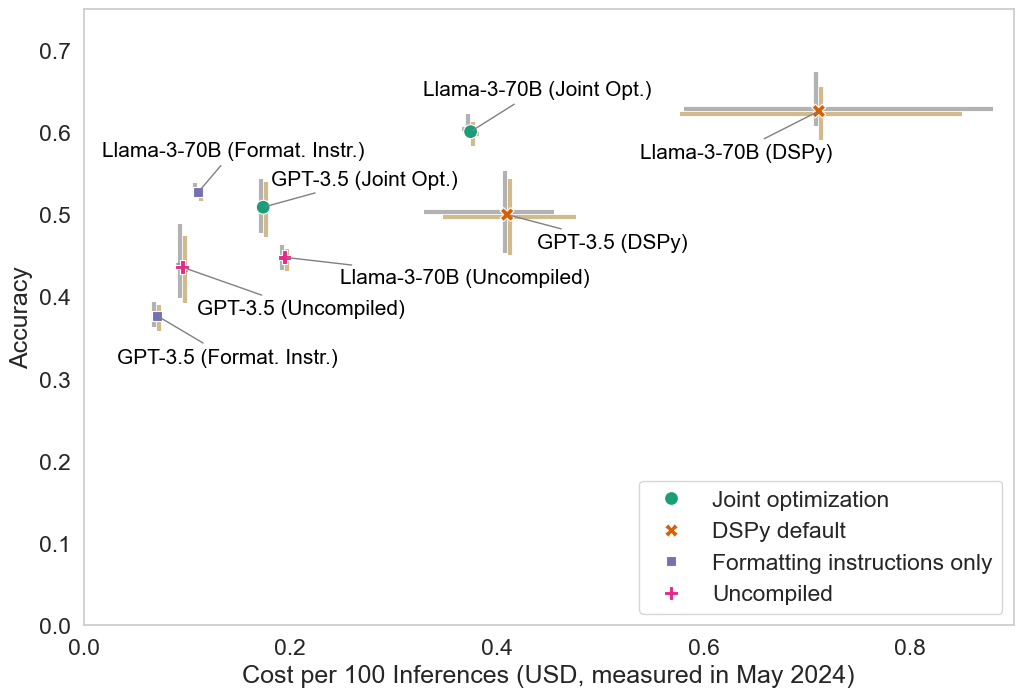

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)  #

# Define a dictionary mapping model names to marker styles
marker_styles = {
    "Llama-3-70B": "S",
    "GPT-3.5": "s",
}

model_name_dict = {
    "llama3_70B_format_instr_2hops2passagesperhop_retrieval_eval_results": "Llama-3-70B",
    "llama3_70B_compiled_acc_optim_2hops2passagesperhop_retrieval_eval_results": "Llama-3-70B",
    "llama3_70B_compiled_joint_optim_2hops2passagesperhop_retrieval_eval_results": "Llama-3-70B",
    "llama3_70B_uncompiled_2hops2passagesperhop_retrieval_eval_results": "Llama-3-70B",

    "gpt_3.5_0125_compiled_acc_optim_2hops2passagesperhop_retrieval_eval_results": "GPT-3.5",
    "gpt_3.5_0125_compiled_joint_optim_2hops2passagesperhop_retrieval_eval_results": "GPT-3.5",
    "gpt_3.5_0125_format_instr_2hops2passagesperhop_retrieval_eval_results": "GPT-3.5",
    "gpt_3.5_0125_uncompiled_2hops2passagesperhop_retrieval_eval_results": "GPT-3.5",
}



# filter eval_results_clean for keys in model_name_dict
eval_results_filtered = {k: v for k, v in eval_results_clean.items() if k in model_name_dict.keys()}

# for each model in eval_results_filtered, only keep the program in the list with the highest mean accuracy across all runs in eval_accuracies
eval_results_filtered_best = {}
for filename, eval_result in eval_results_filtered.items():
    if "joint" in filename:
        best_accuracy = 0
        best_program = None
        for program in eval_result:
            dev_acc = program['trainset_acc']
            if dev_acc > best_accuracy:
                best_accuracy = dev_acc
                best_program = program
        eval_results_filtered_best[filename] = [best_program]
    else:
        eval_results_filtered_best[filename] = eval_result
    
    relevant_keys_dict = {k: eval_results_filtered_best[filename][0][k] for k in ['eval_gold_passages_retrieved_accuracies', 'eval_costs', 'compile_cost'] if k in eval_results_filtered_best[filename][0]}
    print("Best program:", filename)

    print("Mean accuracy:", np.mean(list(relevant_keys_dict['eval_gold_passages_retrieved_accuracies'].values())))
    print("Max accuracy:", max(list(relevant_keys_dict['eval_gold_passages_retrieved_accuracies'].values())))
    print("Min accuracy:", min(list(relevant_keys_dict['eval_gold_passages_retrieved_accuracies'].values())))

    print("Mean eval cost:", np.mean(list(relevant_keys_dict['eval_costs'].values())))
    print("Max eval cost:", max(list(relevant_keys_dict['eval_costs'].values())))
    print("Min eval cost:", min(list(relevant_keys_dict['eval_costs'].values())))

    if type(relevant_keys_dict['compile_cost']) == dict:
        print("Mean compile cost:", np.mean(list(relevant_keys_dict['compile_cost'].values())))
        print("Max compile cost:", max(list(relevant_keys_dict['compile_cost'].values())))
        print("Min compile cost:", min(list(relevant_keys_dict['compile_cost'].values())))
    else:
        print("Compile cost:", relevant_keys_dict['compile_cost'])



# get data for plotting
x = []
x_err_minmax = []
x_err_95ci = []
y = []
y_err_minmax = []
y_err_95ci = []
joint_optimized = []
model_name = []
compile_cost = []
for filename, eval_result in eval_results_filtered_best.items():
    for program in eval_result:
        print(filename, program)
        if type(program['compile_cost']) == dict:
            compile_cost.append(sum(program['compile_cost'].values())/len(program['compile_cost'].values()))
        else:
            compile_cost.append(program['compile_cost'])
        
        x_mean = sum(program['eval_costs'].values())/len(program['eval_costs'])
        x.append(x_mean)
        print("cost per 100 inferences", x_mean/2) # per 100 inferences

        x_err_95ci_lower,x_err_95ci_upper = confidence_interval(list(program['eval_costs'].values()))
        x_err_95ci.append([x_mean - x_err_95ci_lower, x_err_95ci_upper - x_mean])
        x_err_minmax.append([[x_mean - min(program['eval_costs'].values())],[max(program['eval_costs'].values()) - x_mean]])

        y_mean = sum(program['eval_gold_passages_retrieved_accuracies'].values())/len(program['eval_gold_passages_retrieved_accuracies'])
        y.append(y_mean)
        print("accuracy", y_mean)

        y_err_95ci_lower,y_err_95ci_upper = confidence_interval(list(program['eval_gold_passages_retrieved_accuracies'].values()))
        y_err_95ci.append([y_mean - y_err_95ci_lower, y_err_95ci_upper - y_mean])
        y_err_minmax.append([[y_mean - min(program['eval_gold_passages_retrieved_accuracies'].values())],[max(program['eval_gold_passages_retrieved_accuracies'].values()) - y_mean]])
        optimizer = "Uncompiled"
        if "joint_optim" in filename:
            optimizer = "Joint optimization"
        elif "acc_optim" in filename:
            optimizer = "DSPy default"
        elif "format_instr" in filename:
            optimizer = "Formatting instructions only"
        joint_optimized.append(optimizer)
        model_name.append(model_name_dict[filename])
x_err_minmax = np.array(x_err_minmax).reshape(-1, 2)
y_err_minmax = np.array(y_err_minmax).reshape(-1, 2)
x_err_95ci = np.array(x_err_95ci).reshape(-1, 2)
y_err_95ci = np.array(y_err_95ci).reshape(-1, 2)
markers = [marker_styles[model] for model in model_name]

# Function to determine the Pareto frontier
def identify_pareto(scores):
    # Initialize the Pareto front: True if a point is on the front
    pareto_front = [True] * len(scores)
    for i in range(len(scores)):
        for j in range(len(scores)):
            if i == j:
                continue
            if scores[j][0] < scores[i][0] and scores[j][1] >= scores[i][1]:
                pareto_front[i] = False
    return pareto_front

# Determine which programs are on the Pareto frontier
pareto_status = identify_pareto(list(zip(x, y)))
pareto_points = [(x[i], y[i]) for i in range(len(x)) if pareto_status[i]]
pareto_points_sorted = sorted(pareto_points, key=lambda point: point[0])
pareto_x_overall = [point[0] for point in pareto_points_sorted]
pareto_y_overall = [point[1] for point in pareto_points_sorted]


# Determine second pareto frontier of points that have joint_optimized being DSPy optimization
# filter points that have joint_optimized being DSPy optimization
x_dspy = [x[i] for i in range(len(x)) if joint_optimized[i] == "DSPy default"]
y_dspy = [y[i] for i in range(len(y)) if joint_optimized[i] == "DSPy default"]
pareto_status = identify_pareto(list(zip(x_dspy, y_dspy)))
pareto_points = [(x_dspy[i], y_dspy[i]) for i in range(len(x_dspy)) if pareto_status[i]]
pareto_points_sorted = sorted(pareto_points, key=lambda point: point[0])
pareto_x_dspy = [point[0] for point in pareto_points_sorted]
pareto_y_dspy = [point[1] for point in pareto_points_sorted]



# get cost per 100 inferences (200 samples in test set so div by 2)
x = [p/2 for p in x]

# Create the scatter plot with error bars
f, (ax) = plt.subplots(1,1, figsize=(12, 8))
f.subplots_adjust(wspace=0.015)
# Creating the scatter plot with a color map based on 'joint_optimized'
if joint_optimized.count(False) == len(joint_optimized):
    scatter = plt.scatter(x, y, c='blue', alpha=.7)
else:
    scatter_plot = sns.scatterplot(
    x=x,
    y=y,
    hue=joint_optimized,
    palette=sns.color_palette("Dark2")[:4], 
    style=joint_optimized,
    s=100,
    zorder=2,
    ax=ax
    )


# Setting the title and labels
ax.set_ylabel('Accuracy')
ax.set_xlabel('Cost per 100 Inferences (USD, measured in May 2024)')
plt.grid(True)

# Setting the y-axis limits
plt.ylim(0, .75)
ax.set_xlim(0,0.9)

# plot ticks on x axis every 5 units
ax.set_xticks([0,.2, .4, .6, .8])

ax.grid(False)


err_bar_alpha=0.5
x_err_bar_offset=0.0025
y_err_bar_offset=0.003
for i in range(len(x)):
    ax.errorbar(
        x=x[i]-x_err_bar_offset, 
        y=y[i]+y_err_bar_offset, 
        xerr=[[x_err_minmax[i][0]], [x_err_minmax[i][1]]], 
        yerr=[[y_err_minmax[i][0]], [y_err_minmax[i][1]]],
        color=sns.color_palette("Dark2")[-1],
        fmt='',  # Use the same marker as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=3,  # Adjust error bar line width
        zorder=1,
        alpha=err_bar_alpha
    )
    ax.errorbar(
        x=x[i]+x_err_bar_offset,
        y=y[i]-y_err_bar_offset,
        yerr=[[y_err_95ci[i][0]], [y_err_95ci[i][1]]],
        xerr=[[x_err_95ci[i][0]], [x_err_95ci[i][1]]],
        color=sns.color_palette("Dark2")[-2],
        fmt='',  # Use the same marker as the scatter plot
        capsize=0,  # Add caps to the error bars
        elinewidth=3,  # Adjust error bar line width
        zorder=1,
        alpha=err_bar_alpha
    )
    

# Implementing label adjustments using simple lines
strategy_renames = {
    "DSPy default": "DSPy",
    "Formatting instructions only": "Format. Instr.",
    "Joint optimization": "Joint Opt.",
    "Uncompiled": "Uncompiled"
}
for i in range(len(x)):
    annotation_text = f"{model_name[i]} ({strategy_renames[joint_optimized[i]]})"
    x_point = x[i]
    y_point = y[i]
    
    # Define the xytext position for each label (customize as needed)
    if annotation_text == "GPT-3.5 (Joint Opt.)":
        xytext = (140, 20)
    elif annotation_text == "GPT-3.5 (Format. Instr.)":
        xytext = (130,-30)
    elif annotation_text == "GPT-3.5 (DSPy)":
        xytext = (130,-20)
    elif annotation_text == "GPT-3.5 (Uncompiled)":
        xytext = (160, -30)
    elif annotation_text == "Llama-3-70B (Format. Instr.)":
        xytext = (120, 30)  # Adjust position for Llama-3-70B
    elif annotation_text == "Llama-3-70B (Joint Opt.)":
        xytext = (130, 30)
    elif annotation_text == "Llama-3-70B (Uncompiled)":
        xytext = (220, -15)
    elif annotation_text == "Llama-3-70B (DSPy)":
        xytext = (10, -30)
    elif model_name[i] == "Llama-3-8B":
        xytext = (10, -20)  # Adjust position for Llama-3-8B
    elif model_name[i] == "GPT-4":
        xytext = (10, -20)  # Adjust position for GPT-4
    else:
        xytext = (10, -5)  # Default position


    ### WITHOUT OPTIM. LABELS AT POINTS
    # # Define the xytext position for each label (customize as needed)
    # if annotation_text == "GPT-3.5 (Joint Opt.)":
    #     xytext = (80, 10)
    #     annotation_text = "GPT-3.5"
    # elif annotation_text == "GPT-3.5 (Format. Instr.)":
    #     xytext = (80,-20)
    #     annotation_text = "GPT-3.5"
    # elif annotation_text == "GPT-3.5 (DSPy)":
    #     xytext = (90,-20)
    #     annotation_text = "GPT-3.5"
    # elif annotation_text == "GPT-3.5 (Uncompiled)":
    #     xytext = (80, -20)
    #     annotation_text = "GPT-3.5"
    # elif annotation_text == "Llama-3-70B (Format. Instr.)":
    #     xytext = (120, 30)  # Adjust position for Llama-3-70B
    #     annotation_text = "Llama-3-70B"
    # elif annotation_text == "Llama-3-70B (Joint Opt.)":
    #     xytext = (100, 30)
    #     annotation_text = "Llama-3-70B"
    # elif annotation_text == "Llama-3-70B (Uncompiled)":
    #     xytext = (120, -15)
    #     annotation_text = "Llama-3-70B"
    # elif annotation_text == "Llama-3-70B (DSPy)":
    #     xytext = (10, -30)
    #     annotation_text = "Llama-3-70B"
    # else:
    #     xytext = (10, -5)  # Default position

    # Add annotations
    scatter_plot.annotate(
        annotation_text,
        xy=(x_point, y_point),
        xycoords='data',
        xytext=xytext,
        textcoords='offset points',
        size=15,
        ha='right',
        va='center',
        color='black',
        arrowprops=dict(arrowstyle="-", color='gray'),
    )


# hide legend
ax.legend(loc="lower right")


plt.show()
